In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(42)


# Import Necessary Libraries

In [ ]:
!pip install optuna
!pip install optuna-integration

# IMPORT LIBRARIES

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import optuna
import tensorflow as tf

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Import Data

In [ ]:

file_id = "1EIEsAzVWCwsAiOIO190r3g4mVCleNoNs"
csv_url = f"https://drive.google.com/uc?id={file_id}"

# Read the Google Drive file as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()

# Set Date as the index (ensure column name matches your file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display first few tourism demand
df.head()

# Backup
df_backup = df.copy()


In [ ]:
df.head()

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Positive,Neutral,Negative,Total Tourist Arrivals,Sri Lanka Hotels,Sri Lanka Flights,Sri Lanka Visa
Date,,,,,,,,,,,,,
2006-01-01,0,0,0,0,0,0,0,0,0,52103,49,29,0
2006-02-01,1,0,0,0,0,1,0,2,0,52687,41,20,0
2006-03-01,1,0,2,0,1,0,1,3,0,54746,35,20,47
2006-04-01,0,1,2,0,1,1,0,4,1,49776,38,20,0
2006-05-01,3,1,1,5,0,1,4,3,4,43825,34,16,0


In [ ]:
df.columns.to_list()

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Positive',
 'Neutral',
 'Negative',
 'Total Tourist Arrivals',
 'Sri Lanka Hotels',
 'Sri Lanka Flights',
 'Sri Lanka Visa']

# Drop Google Trends

In [ ]:
df.drop(['Sri Lanka Hotels',
 'Sri Lanka Flights',
 'Sri Lanka Visa'], axis=1, inplace=True)

# Pre Processing

In [ ]:
# maximum lag length
max_laglength = 3

# Backup
df_backup = df.copy()

# Create lags
for lag in range(1, max_laglength+1):
    for col in df_backup.columns.to_list():
        df[f"{col}(t-{lag})"] = df[col].shift(lag)

# -----------------------------
# Add month as categorical
# -----------------------------
df["Month"] = df.index.month_name()
df = pd.get_dummies(df, columns=["Month"], prefix="month")

# -----------------------------
# Drop original t=0 variables (optional)
# -----------------------------
cols_to_drop = [
    'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4',
    'Cluster_5', 'Cluster_6', 'Positive', 'Neutral', 'Negative'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# -----------------------------
# Drop rows with NaNs created by lagging
# -----------------------------
df.dropna(inplace=True)

# -----------------------------
# Check
# -----------------------------
df.head()




,Total Tourist Arrivals,Cluster_1(t-1),Cluster_2(t-1),Cluster_3(t-1),Cluster_4(t-1),Cluster_5(t-1),Cluster_6(t-1),Positive(t-1),Neutral(t-1),Negative(t-1),...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,49776,1.0,0.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2006-05-01,43825,0.0,1.0,2.0,0.0,1.0,1.0,0.0,4.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2006-06-01,44066,3.0,1.0,1.0,5.0,0.0,1.0,4.0,3.0,4.0,...,False,False,False,False,True,False,False,False,False,False
2006-07-01,55354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
2006-08-01,52931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df.columns.to_list()

['Total Tourist Arrivals',
 'Cluster_1(t-1)',
 'Cluster_2(t-1)',
 'Cluster_3(t-1)',
 'Cluster_4(t-1)',
 'Cluster_5(t-1)',
 'Cluster_6(t-1)',
 'Positive(t-1)',
 'Neutral(t-1)',
 'Negative(t-1)',
 'Total Tourist Arrivals(t-1)',
 'Cluster_1(t-2)',
 'Cluster_2(t-2)',
 'Cluster_3(t-2)',
 'Cluster_4(t-2)',
 'Cluster_5(t-2)',
 'Cluster_6(t-2)',
 'Positive(t-2)',
 'Neutral(t-2)',
 'Negative(t-2)',
 'Total Tourist Arrivals(t-2)',
 'Cluster_1(t-3)',
 'Cluster_2(t-3)',
 'Cluster_3(t-3)',
 'Cluster_4(t-3)',
 'Cluster_5(t-3)',
 'Cluster_6(t-3)',
 'Positive(t-3)',
 'Neutral(t-3)',
 'Negative(t-3)',
 'Total Tourist Arrivals(t-3)',
 'month_April',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_July',
 'month_June',
 'month_March',
 'month_May',
 'month_November',
 'month_October',
 'month_September']

# Train Test Split

In [ ]:
target = "Total Tourist Arrivals"

# Ensure chronological order
df = df.sort_index()   # index should be datetime

# Define forecast horizon
forecast_horizon = 12  # last 12 months

# Split data
train = df.iloc[:-forecast_horizon]
test  = df.iloc[-forecast_horizon:]

# Separate features and target
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

print(f"Train size: {len(train)}")
print(f"Test size (last 12 months): {len(test)}")


Train size: 222
Test size (last 12 months): 12


# Moving Window

In [ ]:
# MOVING WINDOW APPROACH
tscv = TimeSeriesSplit(
    n_splits=5
)

# XGB Feature Selection

In [ ]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgb_model.fit(X_train, y_train)


# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-04 05:42:25,842] A new study created in memory with name: no-name-df92839b-faf3-4697-a5cc-639ba8086088
[I 2026-02-04 05:42:34,740] Trial 0 finished with value: 2074962790.4 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 2074962790.4.
[I 2026-02-04 05:42:36,696] Trial 1 finished with value: 1807497024.0 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 1807497024.0.
[I 2026-02-04 05:42:39,281] Trial 2 finished with value: 2099909593.6 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 1807497024.0.
[I 2026-02-04 05:42:43,878] Trial 3 finished with va

==== TRAIN METRICS ====
Train MSE : 6852.5771484375
Train RMSE: 82.78029444522107
Train MAE : 62.66938781738281
Train MAPE: 6963040171851776.0
Train R²  : 0.9999984502792358

==== TEST METRICS ====
Test MSE : 212044464.0
Test RMSE: 14561.746598536867
Test MAE : 12034.6318359375
Test MAPE: 0.06180417910218239
Test R²  : 0.8826930522918701


### Feature Importance Plot

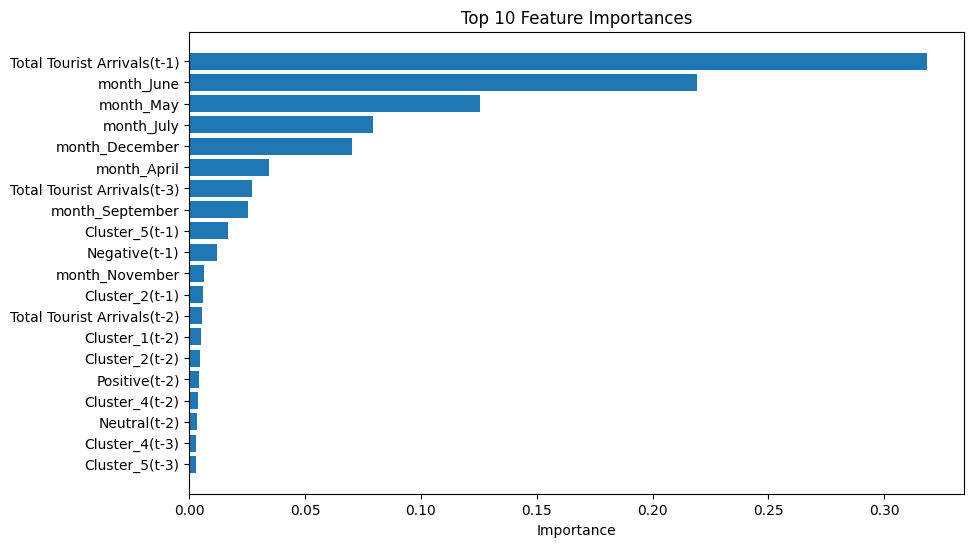

In [ ]:
# IMPORTANCE GRAPH
model = xgb_model

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Convert to DataFrame
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})


# Sort & select top 10
top20 = imp_df.sort_values(by="importance", ascending=False).head(20)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

## Best Elbow

In [ ]:
import numpy as np

elbow_points = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 20])
# Compute differences
diff = np.diff(elbow_points)

# Largest jump → elbow
elbow_index = np.argmax(diff)
best_elbow_point = elbow_points[elbow_index]

print("Best elbow point:", best_elbow_point)

Best elbow point: 16


[I 2026-02-04 05:44:17,352] A new study created in memory with name: no-name-75698c01-a5ac-4df2-9c0d-3554c8a58695



========== TUNING FOR TOP 1 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:44:19,426] Trial 0 finished with value: 1640243897.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1640243897.6.
[I 2026-02-04 05:44:20,182] Trial 1 finished with value: 1737135449.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1640243897.6.
[I 2026-02-04 05:44:22,362] Trial 2 finished with value: 1739900377.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:45:05,993] A new study created in memory with name: no-name-347f8114-ae5b-48e0-be6d-73135f89586f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:45:07,014] Trial 0 finished with value: 1655854284.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1655854284.8.
[I 2026-02-04 05:45:07,727] Trial 1 finished with value: 1701384755.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1655854284.8.
[I 2026-02-04 05:45:08,315] Trial 2 finished with value: 1689194982.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:45:40,794] A new study created in memory with name: no-name-a8a83e16-3554-405c-a523-28975abc0bd3


[I 2026-02-04 05:45:40,706] Trial 49 finished with value: 1660533414.4 and parameters: {'n_estimators': 614, 'max_depth': 3, 'learning_rate': 0.023674537246094755, 'subsample': 0.6631725255633723, 'colsample_bytree': 0.7277121011179679, 'gamma': 2.736959844079149, 'min_child_weight': 6, 'reg_alpha': 3.132621765068232, 'reg_lambda': 1.955507407972173}. Best is trial 12 with value: 1512739552.0.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.03163393826748552, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8384389352084881, 'gamma': 2.9005404163726607, 'min_child_weight': 1, 'reg_alpha': 2.9020226051267786, 'reg_lambda': 0.017902345021022392}

========== TUNING FOR TOP 3 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:45:41,664] Trial 0 finished with value: 1621829094.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1621829094.4.
[I 2026-02-04 05:45:42,488] Trial 1 finished with value: 1707526208.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1621829094.4.
[I 2026-02-04 05:45:43,203] Trial 2 finished with value: 1691706969.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:46:12,803] A new study created in memory with name: no-name-1c13921b-e343-4d82-b63a-90825be73862


[I 2026-02-04 05:46:12,709] Trial 49 finished with value: 1536164320.0 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.05846610134785747, 'subsample': 0.958809665285555, 'colsample_bytree': 0.8271119641971834, 'gamma': 2.3136488836279887, 'min_child_weight': 1, 'reg_alpha': 3.813004450878059, 'reg_lambda': 0.639272919569603}. Best is trial 42 with value: 1491079558.4.
Best Parameters: {'n_estimators': 497, 'max_depth': 2, 'learning_rate': 0.09950904103276229, 'subsample': 0.89937816891109, 'colsample_bytree': 0.6738750906774036, 'gamma': 2.20315004023307, 'min_child_weight': 1, 'reg_alpha': 3.7976377965798145, 'reg_lambda': 2.6843098848810643}

========== TUNING FOR TOP 4 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:46:13,877] Trial 0 finished with value: 1507872032.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1507872032.0.
[I 2026-02-04 05:46:15,617] Trial 1 finished with value: 1525255955.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 1507872032.0.
[I 2026-02-04 05:46:17,094] Trial 2 finished with value: 1532572953.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:46:48,770] A new study created in memory with name: no-name-2ae21439-c443-4ad3-99e4-4b8ec182269b


[I 2026-02-04 05:46:48,676] Trial 49 finished with value: 1460975417.6 and parameters: {'n_estimators': 356, 'max_depth': 4, 'learning_rate': 0.25369637354610824, 'subsample': 0.8622187118198226, 'colsample_bytree': 0.795676550338633, 'gamma': 3.3474130067643797, 'min_child_weight': 1, 'reg_alpha': 3.7641189272537483, 'reg_lambda': 3.838347463471466}. Best is trial 12 with value: 1374019820.8.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.029765845434229676, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8382475684166885, 'gamma': 3.577576021601927, 'min_child_weight': 1, 'reg_alpha': 2.7581629187110615, 'reg_lambda': 0.015785633798671334}

========== TUNING FOR TOP 5 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:46:50,002] Trial 0 finished with value: 1362467353.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1362467353.6.
[I 2026-02-04 05:46:50,819] Trial 1 finished with value: 1358235750.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1358235750.4.
[I 2026-02-04 05:46:51,532] Trial 2 finished with value: 1435739692.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:47:29,104] A new study created in memory with name: no-name-b5ae1a51-69e2-449d-94f1-dd39ba8878fb


[I 2026-02-04 05:47:29,002] Trial 49 finished with value: 1475413907.2 and parameters: {'n_estimators': 1040, 'max_depth': 3, 'learning_rate': 0.14888154658719227, 'subsample': 0.9816246621195676, 'colsample_bytree': 0.9352351973046741, 'gamma': 3.037759118205309, 'min_child_weight': 6, 'reg_alpha': 1.2402405392541422, 'reg_lambda': 2.617862824643812}. Best is trial 12 with value: 1200795923.2.
Best Parameters: {'n_estimators': 502, 'max_depth': 2, 'learning_rate': 0.029765845434229676, 'subsample': 0.9943435740037198, 'colsample_bytree': 0.8382475684166885, 'gamma': 3.577576021601927, 'min_child_weight': 1, 'reg_alpha': 2.7581629187110615, 'reg_lambda': 0.015785633798671334}

========== TUNING FOR TOP 6 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:47:31,704] Trial 0 finished with value: 1379260307.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1379260307.2.
[I 2026-02-04 05:47:33,011] Trial 1 finished with value: 1264643200.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1264643200.0.
[I 2026-02-04 05:47:33,766] Trial 2 finished with value: 1404459680.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:48:16,033] A new study created in memory with name: no-name-3f38a111-756f-4926-a65a-998706dd99d7


[I 2026-02-04 05:48:15,902] Trial 49 finished with value: 1465144768.0 and parameters: {'n_estimators': 614, 'max_depth': 4, 'learning_rate': 0.21177862539705616, 'subsample': 0.6730920741452997, 'colsample_bytree': 0.8208820206786354, 'gamma': 3.0468418921181866, 'min_child_weight': 6, 'reg_alpha': 2.1354764127537615, 'reg_lambda': 0.8651138008519459}. Best is trial 28 with value: 1207805491.2.
Best Parameters: {'n_estimators': 693, 'max_depth': 2, 'learning_rate': 0.017711160385449273, 'subsample': 0.8132111042312398, 'colsample_bytree': 0.8852098043303755, 'gamma': 1.3235859990233958, 'min_child_weight': 1, 'reg_alpha': 4.267519151318105, 'reg_lambda': 1.2065211503083022}

========== TUNING FOR TOP 7 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:48:17,400] Trial 0 finished with value: 1401986086.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1401986086.4.
[I 2026-02-04 05:48:18,276] Trial 1 finished with value: 1286646105.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1286646105.6.
[I 2026-02-04 05:48:19,105] Trial 2 finished with value: 1362214809.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:48:57,887] A new study created in memory with name: no-name-8177ba33-114b-4c17-9ecb-9511ff8e4c1a



========== TUNING FOR TOP 8 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:49:01,050] Trial 0 finished with value: 1376139699.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1376139699.2.
[I 2026-02-04 05:49:01,952] Trial 1 finished with value: 1195698726.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1195698726.4.
[I 2026-02-04 05:49:02,784] Trial 2 finished with value: 1364415929.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:49:43,570] A new study created in memory with name: no-name-6e6f7b4f-bf8a-4794-8811-4c18962ff2de


[I 2026-02-04 05:49:43,444] Trial 49 finished with value: 1265281184.0 and parameters: {'n_estimators': 982, 'max_depth': 2, 'learning_rate': 0.03674277468910635, 'subsample': 0.9125152065128398, 'colsample_bytree': 0.9584647851394762, 'gamma': 1.1544324995943986, 'min_child_weight': 6, 'reg_alpha': 3.2062941975670345, 'reg_lambda': 0.4846390520431886}. Best is trial 32 with value: 1022112160.0.
Best Parameters: {'n_estimators': 528, 'max_depth': 2, 'learning_rate': 0.05188930196254866, 'subsample': 0.7301462456888995, 'colsample_bytree': 0.9385415311204899, 'gamma': 1.1914713907035908, 'min_child_weight': 1, 'reg_alpha': 4.424333141500365, 'reg_lambda': 0.3295432061399881}

========== TUNING FOR TOP 9 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:49:44,994] Trial 0 finished with value: 1385533824.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1385533824.0.
[I 2026-02-04 05:49:45,906] Trial 1 finished with value: 1155445100.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1155445100.8.
[I 2026-02-04 05:49:46,766] Trial 2 finished with value: 1301478764.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:50:38,091] A new study created in memory with name: no-name-5b8a8757-6204-4bb9-8d2f-c97aee3eda51


[I 2026-02-04 05:50:37,930] Trial 49 finished with value: 1131000921.6 and parameters: {'n_estimators': 630, 'max_depth': 2, 'learning_rate': 0.1753027070609854, 'subsample': 0.6874882227732775, 'colsample_bytree': 0.6598856714991777, 'gamma': 0.16979656056734566, 'min_child_weight': 2, 'reg_alpha': 3.8093735947928895, 'reg_lambda': 2.5552696053490465}. Best is trial 33 with value: 1070184550.4.
Best Parameters: {'n_estimators': 743, 'max_depth': 2, 'learning_rate': 0.22288110659340643, 'subsample': 0.7369596606866474, 'colsample_bytree': 0.6113014543697181, 'gamma': 1.1232111853597002, 'min_child_weight': 1, 'reg_alpha': 4.988075176684156, 'reg_lambda': 1.4479288648402937}

========== TUNING FOR TOP 10 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:50:39,789] Trial 0 finished with value: 1502275737.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1502275737.6.
[I 2026-02-04 05:50:42,470] Trial 1 finished with value: 1213893900.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1213893900.8.
[I 2026-02-04 05:50:43,366] Trial 2 finished with value: 1364220300.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:51:40,751] A new study created in memory with name: no-name-de15de9a-070f-48e5-b2c5-830d72a1c28e


[I 2026-02-04 05:51:40,591] Trial 49 finished with value: 1353376332.8 and parameters: {'n_estimators': 1006, 'max_depth': 4, 'learning_rate': 0.044079299179572574, 'subsample': 0.7409561451973841, 'colsample_bytree': 0.9754744345214563, 'gamma': 3.010530087909533, 'min_child_weight': 6, 'reg_alpha': 3.3350705438263466, 'reg_lambda': 2.7809138999913223}. Best is trial 31 with value: 1111248716.8.
Best Parameters: {'n_estimators': 669, 'max_depth': 2, 'learning_rate': 0.0249356721622846, 'subsample': 0.8119611101107078, 'colsample_bytree': 0.8396186239634399, 'gamma': 3.61461870675843, 'min_child_weight': 1, 'reg_alpha': 2.647544135574885, 'reg_lambda': 0.009019050309347687}

========== TUNING FOR TOP 13 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:51:42,228] Trial 0 finished with value: 1673935974.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1673935974.4.
[I 2026-02-04 05:51:43,239] Trial 1 finished with value: 1231529497.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1231529497.6.
[I 2026-02-04 05:51:44,235] Trial 2 finished with value: 1465212672.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:52:45,051] A new study created in memory with name: no-name-dd1d4d19-4530-4039-a99f-f1f080dd8cf9



========== TUNING FOR TOP 16 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:52:46,558] Trial 0 finished with value: 2033819955.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2033819955.2.
[I 2026-02-04 05:52:47,628] Trial 1 finished with value: 1458859123.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1458859123.2.
[I 2026-02-04 05:52:50,578] Trial 2 finished with value: 1549824371.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-04 05:54:09,633] A new study created in memory with name: no-name-ac31e3d5-db98-4bfe-b46c-4e33731e258c



========== TUNING FOR TOP 20 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 05:54:11,226] Trial 0 finished with value: 1865172326.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1865172326.4.
[I 2026-02-04 05:54:12,381] Trial 1 finished with value: 1403159091.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1403159091.2.
[I 2026-02-04 05:54:13,511] Trial 2 finished with value: 1480354176.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

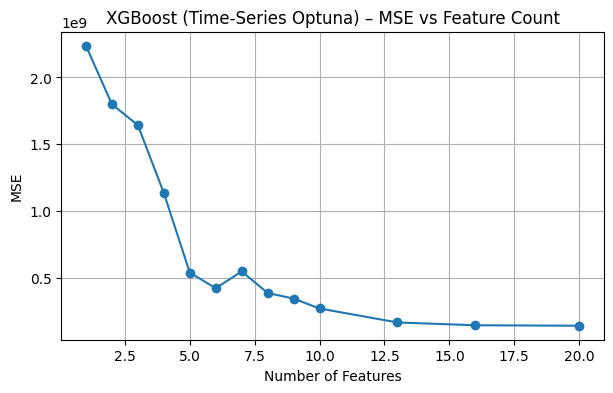

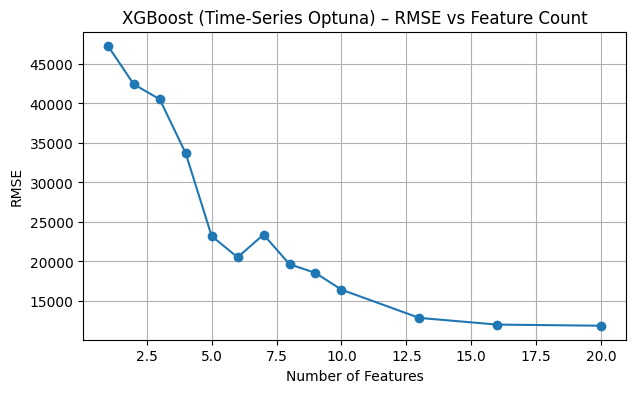

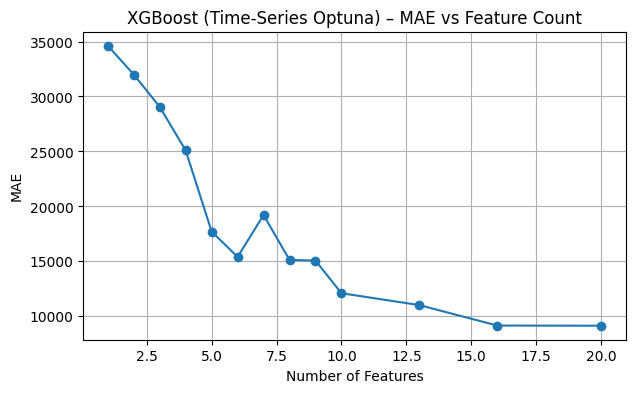

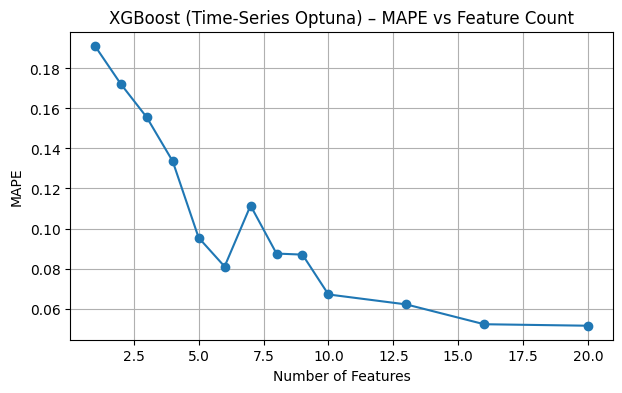

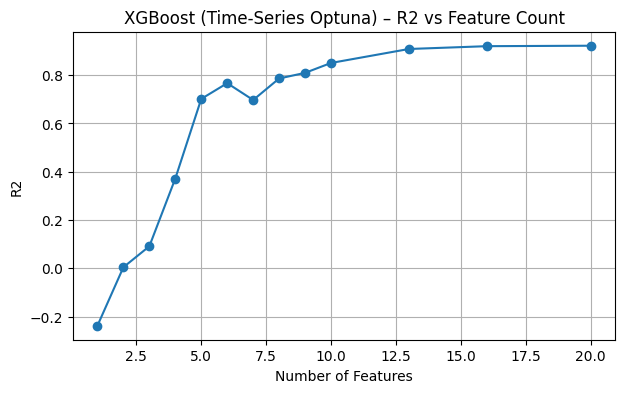

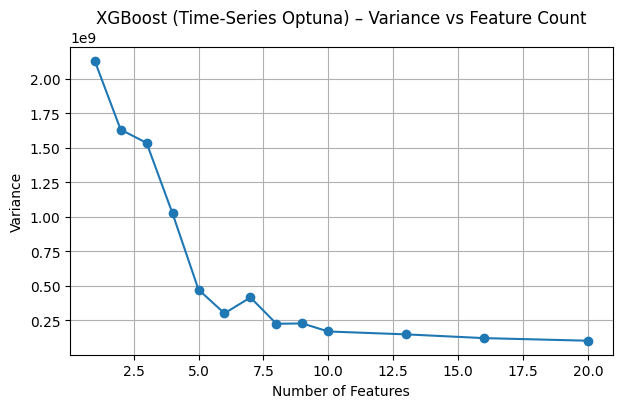

In [ ]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit

# --------------------------------------------------------------
# STEP 1 — Optuna Objective (TIME SERIES SAFE)
# --------------------------------------------------------------

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []

    for train_idx, val_idx in tscv.split(X_train_sub):
        X_tr = X_train_sub.iloc[train_idx]
        X_val = X_train_sub.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        rmse = mean_squared_error(y_val, preds)
        rmses.append(rmse)

    return np.mean(rmses)


# --------------------------------------------------------------
# STEP 2 — Loop Through Elbow Points
# --------------------------------------------------------------

results = []

for n in elbow_points:
    print(f"\n========== TUNING FOR TOP {n} FEATURES ==========")

    # ------------------------
    # Select top-N features
    # ------------------------
    top_features = (
        imp_df.sort_values("importance", ascending=False)
              .head(n)["feature"]
              .tolist()
    )

    X_train_sub = X_train[top_features]
    X_test_sub  = X_test[top_features]

    # ------------------------
    # Optuna Study
    # ------------------------
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best Parameters:", study.best_params)

    # ------------------------
    # Train Final Model
    # ------------------------
    final_model = XGBRegressor(
        **study.best_params,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    final_model.fit(X_train_sub, y_train)

    # ------------------------
    # Test Evaluation
    # ------------------------
    y_pred = final_model.predict(X_test_sub)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    var  = np.var(y_test - y_pred)

    results.append([n, mse, rmse, mae, mape, r2, var])


# --------------------------------------------------------------
# STEP 3 — Metric Table
# --------------------------------------------------------------

metric_df = pd.DataFrame(
    results,
    columns=["Features", "MSE", "RMSE", "MAE", "MAPE", "R2", "Variance"]
)

print("\nFINAL METRIC TABLE:")
print(metric_df)


# --------------------------------------------------------------
# STEP 4 — Plot Metrics
# --------------------------------------------------------------

metrics = ["MSE", "RMSE", "MAE", "MAPE", "R2", "Variance"]

for m in metrics:
    plt.figure(figsize=(7, 4))
    plt.plot(metric_df["Features"], metric_df[m], marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(m)
    plt.title(f"XGBoost (Time-Series Optuna) – {m} vs Feature Count")
    plt.grid(True)
    plt.show()



# Selected Features

In [ ]:
selected_features = top20['feature'][:16].to_list()

In [ ]:
selected_features

['Total Tourist Arrivals(t-1)',
 'month_June',
 'month_May',
 'month_July',
 'month_December',
 'month_April',
 'Total Tourist Arrivals(t-3)',
 'month_September',
 'Cluster_5(t-1)',
 'Negative(t-1)',
 'month_November',
 'Cluster_2(t-1)',
 'Total Tourist Arrivals(t-2)',
 'Cluster_1(t-2)',
 'Cluster_2(t-2)',
 'Positive(t-2)']

## New X_Train X_Test

In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [ ]:
selected_features

['Total Tourist Arrivals(t-1)',
 'month_June',
 'month_May',
 'month_July',
 'month_December',
 'month_April',
 'Total Tourist Arrivals(t-3)',
 'month_September',
 'Cluster_5(t-1)',
 'Negative(t-1)',
 'month_November',
 'Cluster_2(t-1)',
 'Total Tourist Arrivals(t-2)',
 'Cluster_1(t-2)',
 'Cluster_2(t-2)',
 'Positive(t-2)']

# XGB

In [ ]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):
    params = {
           "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**study.best_params,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        n_jobs=-1,
        tree_method="hist")

xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-04 06:13:29,511] A new study created in memory with name: no-name-15ef6807-13a8-46ec-876b-2b0520fb8a13
[I 2026-02-04 06:13:31,026] Trial 0 finished with value: 2033819955.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2033819955.2.
[I 2026-02-04 06:13:32,081] Trial 1 finished with value: 1458859123.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1458859123.2.
[I 2026-02-04 06:13:35,049] Trial 2 finished with value: 1549824371.2 and parameters: {'n_esti

==== TRAIN METRICS ====
Train MSE : 13562784.0
Train RMSE: 3682.7685238146587
Train MAE : 2909.2548828125
Train MAPE: 2.4208492110597325e+17
Train R²  : 0.9968985319137573

==== TEST METRICS ====
Test MSE : 114929696.0
Test RMSE: 10720.526852725103
Test MAE : 8111.11962890625
Test MAPE: 0.045960042625665665
Test R²  : 0.9364187717437744


#  Scale X_train, X_test

In [ ]:
month_cols = [col for col in X_train.columns if 'month_' in col]
num_cols = [col for col in X_train.columns if col not in month_cols]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# scale numeric features
X_train_num_scaled = scaler_X.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler_X.transform(X_test[num_cols])

y_train_scaled = pd.Series(
    scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten(),
    index=y_train.index
)

y_test_scaled = pd.Series(
    scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten(),
    index=y_test.index
)

# add the categorical columns
# Rebuild X_train and X_test as DataFrames
X_train_scaled = pd.DataFrame(
    np.hstack([X_train_num_scaled, X_train[month_cols].values]),
    index=X_train.index,
    columns=num_cols + month_cols
)

X_test_scaled = pd.DataFrame(
    np.hstack([X_test_num_scaled, X_test[month_cols].values]),
    index=X_test.index,
    columns=num_cols + month_cols
)


# SVR

In [ ]:

# =============================
# SVR Objective Function
# =============================
def objective_svr(trial):

    params = {
        "C": trial.suggest_float("C", 0.1, 100.0, log=True),
        "epsilon": trial.suggest_float("epsilon", 0.001, 1.0, log=True),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = SVR(**params)
        model.fit(X_t, y_t)

        preds = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, preds))

    return np.mean(fold_scores)



# =============================
# RUN OPTUNA
# =============================
study_svr = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_params



# =============================
# FIT FINAL SVR MODEL
# =============================
svr_model = SVR(**best_params_svr)
svr_model.fit(X_train_scaled, y_train_scaled)

# Train predictions
train_pred_scaled = svr_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

# Test predictions
test_pred_scaled = svr_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()


print("==== SVR TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== SVR TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))




[I 2026-02-04 06:19:51,764] A new study created in memory with name: no-name-58a97b69-4fbe-4794-8995-be4b08dfbe00
[I 2026-02-04 06:19:51,798] Trial 0 finished with value: 0.9278004335159995 and parameters: {'C': 1.3292918943162166, 'epsilon': 0.711447600934342, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 0.9278004335159995.
[I 2026-02-04 06:19:51,845] Trial 1 finished with value: 0.6306013137220927 and parameters: {'C': 39.67605077052987, 'epsilon': 0.06358358856676251, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 1 with value: 0.6306013137220927.
[I 2026-02-04 06:19:51,881] Trial 2 finished with value: 0.29833062192551507 and parameters: {'C': 0.3511356313970407, 'epsilon': 0.0035498788321965025, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.29833062192551507.
[I 2026-02-04 06:19:51,919] Trial 3 finished with value: 0.50641406264327 and parameters: {'C': 0.262108787826544, 'epsilon': 0.007523742884534853, 'gamma': 'auto', 'kernel': 'rbf'

==== SVR TRAIN METRICS ====
Train RMSE: 63145.35262424596
Train MAE : 29838.44421239952
Train MAPE: 1.0262881688827017e+19
Train R²  : 0.08820252260574346

==== SVR TEST METRICS ====
Test RMSE: 28452.100853663385
Test MAE : 22951.917976502602
Test MAPE: 0.11729702941539677
Test R²  : 0.5521572821829615


In [ ]:
X_train.shape

(222, 16)

# ANN

In [ ]:
def objective_ann(trial):

    params = {
        "hidden1": trial.suggest_int("hidden1", 1, 256),
        "hidden2": trial.suggest_int("hidden2", 1, 256),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    }

    tscv = TimeSeriesSplit(n_splits=5)
    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = MLPRegressor(
            hidden_layer_sizes=(params["hidden1"], params["hidden2"]),
            learning_rate_init=params["lr"],
            alpha=params["alpha"],
            max_iter=500,
            random_state=42,
            early_stopping=True,
            n_iter_no_change=20
        )

        model.fit(X_t, y_t)

        preds_scaled = model.predict(X_v)

        preds = scaler_y.inverse_transform(
            preds_scaled.reshape(-1, 1)
        ).flatten()

        y_val = scaler_y.inverse_transform(
            y_v.to_numpy().reshape(-1, 1)
        ).flatten()

        fold_scores.append(mean_squared_error(y_val, preds))

    return np.mean(fold_scores)



# -----------------------------
# Run Optuna
# -----------------------------
study_ann = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_ann.optimize(objective_ann, n_trials=100)
best_params_ann = study_ann.best_params

# -----------------------------
# Fit final ANN model
# -----------------------------
ann_model = MLPRegressor(
    hidden_layer_sizes=(best_params_ann["hidden1"], best_params_ann["hidden2"]),
    learning_rate_init=best_params_ann["lr"],
    alpha=best_params_ann["alpha"],
    random_state=42,
    max_iter=500
)
ann_model.fit(X_train_scaled, y_train_scaled)

# -----------------------------
# Predictions (rescale to original target)
# -----------------------------
train_pred_scaled = ann_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

test_pred_scaled = ann_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# -----------------------------
# Metrics
# -----------------------------
print("==== TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))


[I 2026-02-04 06:16:34,301] A new study created in memory with name: no-name-4d2be1e9-8715-4904-a87d-b0b45f88ea14
[I 2026-02-04 06:16:35,495] Trial 0 finished with value: 804682549.2910545 and parameters: {'hidden1': 96, 'hidden2': 244, 'lr': 0.0029106359131330704, 'alpha': 0.0006251373574521745}. Best is trial 0 with value: 804682549.2910545.
[I 2026-02-04 06:16:38,118] Trial 1 finished with value: 1386656556.8067536 and parameters: {'hidden1': 40, 'hidden2': 40, 'lr': 0.00013066739238053285, 'alpha': 0.003967605077052989}. Best is trial 0 with value: 804682549.2910545.
[I 2026-02-04 06:16:42,106] Trial 2 finished with value: 1462151510.265445 and parameters: {'hidden1': 154, 'hidden2': 182, 'lr': 0.00010994335574766199, 'alpha': 0.008123245085588688}. Best is trial 0 with value: 804682549.2910545.
[I 2026-02-04 06:16:45,931] Trial 3 finished with value: 1006102035.8835338 and parameters: {'hidden1': 214, 'hidden2': 55, 'lr': 0.0002310201887845295, 'alpha': 3.5498788321965036e-05}. Be

==== TRAIN METRICS ====
Train RMSE: 3864.682181251209
Train MAE : 2609.4909268461006
Train MAPE: 2.312070739502213e+17
Train R²  : 0.996584587447618

==== TEST METRICS ====
Test RMSE: 8842.658672816433
Test MAE : 6824.432831515612
Test MAPE: 0.036255539157394
Test R²  : 0.9567423860096744


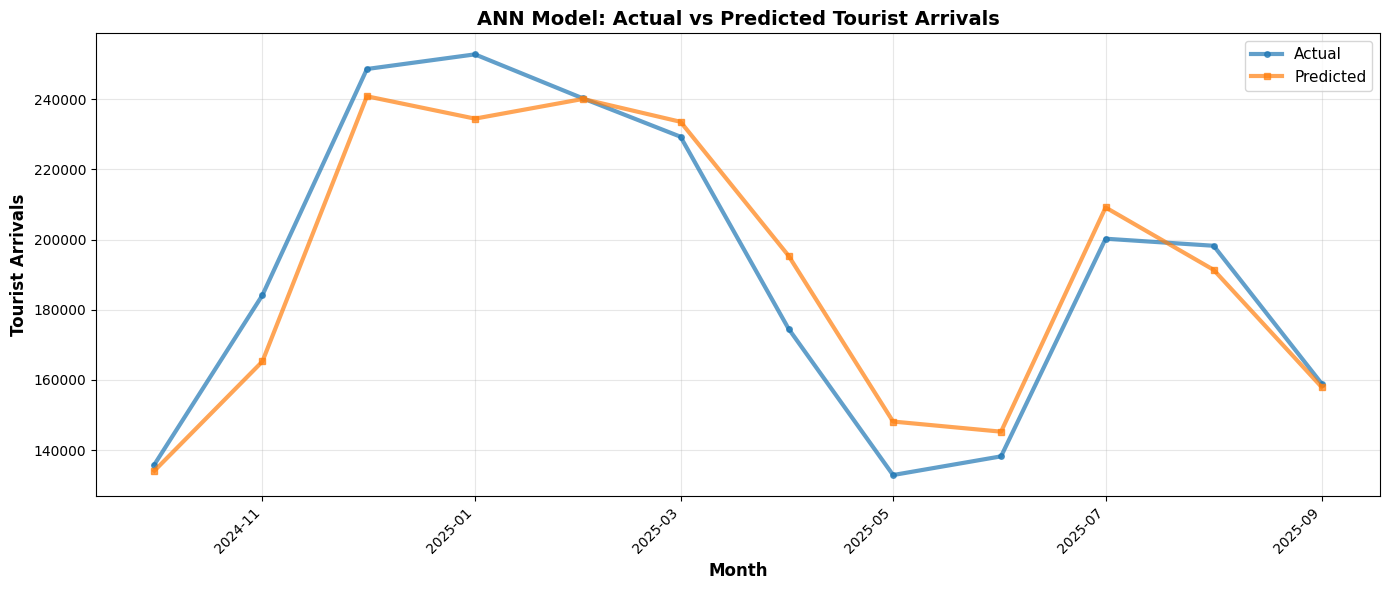

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure with appropriate size
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(y_test.index, y_test.values,
         label='Actual', marker='o', linewidth=3, markersize=4, alpha=0.7)

# Plot predicted values
plt.plot(y_test.index, test_pred,
         label='Predicted', marker='s', linewidth=3, markersize=4, alpha=0.7)

# Formatting
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Tourist Arrivals', fontsize=12, fontweight='bold')
plt.title('ANN Model: Actual vs Predicted Tourist Arrivals', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =============================================
# 1. BEST HYPERPARAMETERS SUMMARY
# =============================================
print("=" * 70)
print("BEST HYPERPARAMETERS FROM OPTUNA OPTIMIZATION")
print("=" * 70)
print(f"Hidden Layer 1 Size:  {best_params_ann['hidden1']}")
print(f"Hidden Layer 2 Size:  {best_params_ann['hidden2']}")
print(f"Learning Rate:        {best_params_ann['lr']:.6f}")
print(f"L2 Regularization:    {best_params_ann['alpha']:.6f}")
print(f"\nBest CV MSE Score:    {study_ann.best_value:.6f}")
print(f"Best Trial Number:    {study_ann.best_trial.number}")
print("=" * 70)



BEST HYPERPARAMETERS FROM OPTUNA OPTIMIZATION
Hidden Layer 1 Size:  147
Hidden Layer 2 Size:  229
Learning Rate:        0.001388
L2 Regularization:    0.000401

Best CV MSE Score:    711715254.151137
Best Trial Number:    43


RESIDUAL CORRECTION: ANN + XGBoost

[Step 1] Computing ANN residuals on training data...
Training residuals - Mean: 23.2162, Std: 3864.6124

[Step 2] Preparing data for residual correction model...
Residual training data shape: (222, 16)
Residual test data shape: (12, 16)

[Step 3] Optimizing XGBoost for residual correction...


  0%|          | 0/100 [00:00<?, ?it/s]


✓ Best residual model MSE: 14968673.280310
✓ Best hyperparameters:
  - n_estimators: 113
  - max_depth: 2
  - learning_rate: 0.01083027745414684
  - subsample: 0.778848861165266
  - colsample_bytree: 0.74297401122219
  - gamma: 1.5550103633220926
  - min_child_weight: 5
  - reg_alpha: 2.4098520639996184
  - reg_lambda: 0.55870680048275

[Step 4] Training final residual correction model...
✓ Residual model trained successfully!

[Step 5] Generating corrected predictions...

PERFORMANCE COMPARISON

ANN Only - Train Metrics:
  RMSE: 3864.682181
  MAE:  2609.490927
  MAPE: 231207073950221312.000000
  R²:   0.996585

ANN Only - Test Metrics:
  RMSE: 8842.658673
  MAE:  6824.432832
  MAPE: 0.036256
  R²:   0.956742

ANN + XGBoost (Corrected) - Train Metrics:
  RMSE: 3566.040902
  MAE:  2447.578320
  MAPE: 230304738621768416.000000
  R²:   0.997092

ANN + XGBoost (Corrected) - Test Metrics:
  RMSE: 8658.837480
  MAE:  6895.191497
  MAPE: 0.036336
  R²:   0.958522

IMPROVEMENT ANALYSIS

Test 

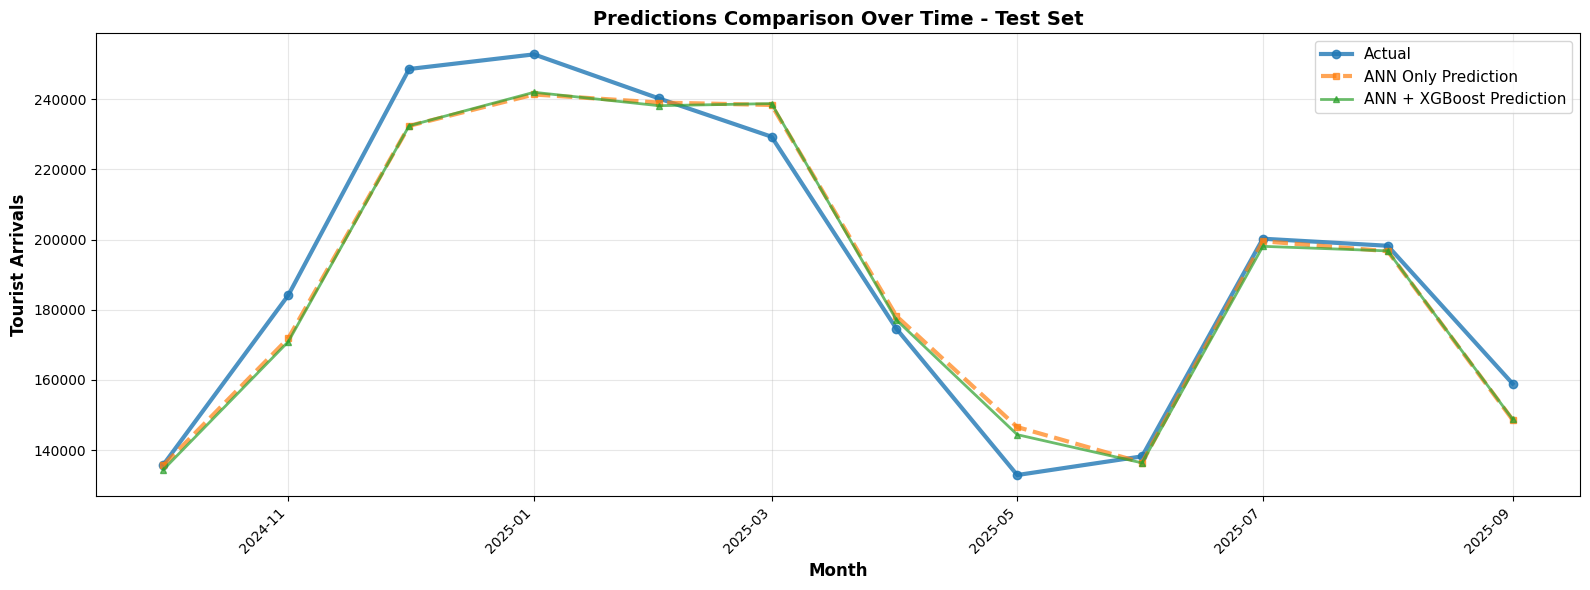

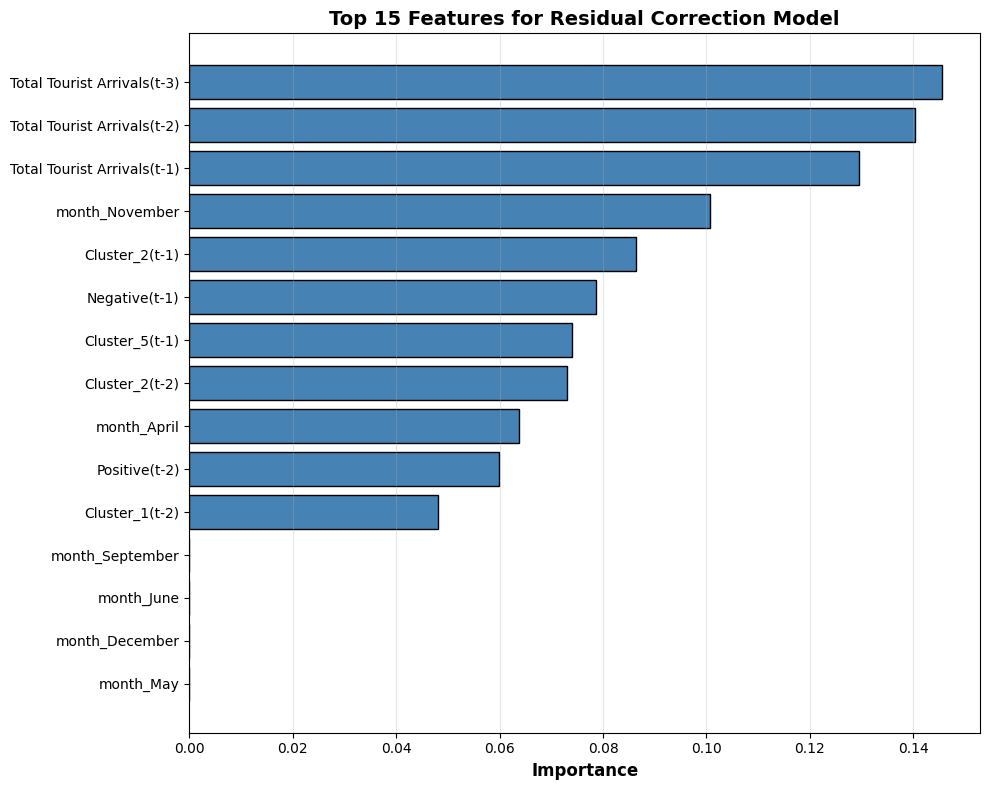


✅ RESIDUAL CORRECTION COMPLETE!

Final Test Set Performance:
  ANN Only:           RMSE = 8842.658673, R² = 0.956742
  ANN + XGBoost:      RMSE = 8658.837480, R² = 0.958522
  Improvement:        +2.08% RMSE, +0.001780 R²


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("RESIDUAL CORRECTION: ANN + XGBoost")
print("=" * 70)

# =============================================
# STEP 1: Get ANN Residuals on Training Data
# =============================================
print("\n[Step 1] Computing ANN residuals on training data...")

train_pred_scaled = ann_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

test_pred_scaled = ann_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# ANN predictions on training data
ann_train_pred = train_pred
ann_test_pred = test_pred

# Calculate residuals (actual - predicted)
train_residuals = y_train.values - ann_train_pred
test_residuals_actual = y_test.values - ann_test_pred  # For evaluation

print(f"Training residuals - Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}")

# =============================================
# STEP 2: Prepare Data for Residual Model
# =============================================
print("\n[Step 2] Preparing data for residual correction model...")

# Use ONLY original features
X_train_residual = X_train.copy()
X_test_residual = X_test.copy()

# Target is the residual
y_train_residual = train_residuals

print(f"Residual training data shape: {X_train_residual.shape}")
print(f"Residual test data shape: {X_test_residual.shape}")

# =============================================
# STEP 3: Optimize XGBoost for Residual Correction
# =============================================
print("\n[Step 3] Optimizing XGBoost for residual correction...")

import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

def objective_residual(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 3),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 3),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_residual):
        X_t = X_train_residual.iloc[train_idx]
        X_v = X_train_residual.iloc[val_idx]
        y_t = y_train_residual[train_idx]
        y_v = y_train_residual[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t, verbose=False)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)

# Run optimization
study_residual = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_residual.optimize(objective_residual, n_trials=100, show_progress_bar=True)

best_params_residual = study_residual.best_params

print(f"\n✓ Best residual model MSE: {study_residual.best_value:.6f}")
print(f"✓ Best hyperparameters:")
for param, value in best_params_residual.items():
    print(f"  - {param}: {value}")

# =============================================
# STEP 4: Train Final Residual Correction Model
# =============================================
print("\n[Step 4] Training final residual correction model...")

xgb_residual_model = XGBRegressor(
    **best_params_residual,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_residual_model.fit(X_train_residual, y_train_residual, verbose=False)
print("✓ Residual model trained successfully!")

# =============================================
# STEP 5: Make Corrected Predictions
# =============================================
print("\n[Step 5] Generating corrected predictions...")

# Predict residuals
predicted_train_residuals = xgb_residual_model.predict(X_train_residual)
predicted_test_residuals = xgb_residual_model.predict(X_test_residual)

# Corrected predictions = ANN predictions + predicted residuals
train_pred_corrected = ann_train_pred + predicted_train_residuals
test_pred_corrected = ann_test_pred + predicted_test_residuals

# =============================================
# STEP 6: Evaluate Models
# =============================================
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)

def print_metrics(y_true, y_pred, model_name, dataset="Train"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} - {dataset} Metrics:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  MAPE: {mape:.6f}")
    print(f"  R²:   {r2:.6f}")

    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

# ANN Only
ann_train_metrics = print_metrics(y_train, ann_train_pred, "ANN Only", "Train")
ann_test_metrics = print_metrics(y_test, ann_test_pred, "ANN Only", "Test")

# ANN + XGBoost Residual Correction
corrected_train_metrics = print_metrics(y_train, train_pred_corrected, "ANN + XGBoost (Corrected)", "Train")
corrected_test_metrics = print_metrics(y_test, test_pred_corrected, "ANN + XGBoost (Corrected)", "Test")

# Calculate improvements
print("\n" + "=" * 70)
print("IMPROVEMENT ANALYSIS")
print("=" * 70)

test_rmse_improvement = ((ann_test_metrics['RMSE'] - corrected_test_metrics['RMSE']) /
                         ann_test_metrics['RMSE'] * 100)
test_mae_improvement = ((ann_test_metrics['MAE'] - corrected_test_metrics['MAE']) /
                        ann_test_metrics['MAE'] * 100)
test_r2_improvement = corrected_test_metrics['R2'] - ann_test_metrics['R2']

print(f"\nTest Set Improvements:")
print(f"  RMSE: {test_rmse_improvement:+.2f}%")
print(f"  MAE:  {test_mae_improvement:+.2f}%")
print(f"  R²:   {test_r2_improvement:+.6f} (absolute change)")

# =============================================
# STEP 7: Visualizations
# =============================================

# =============================================
# Plot: Time Series Comparison
# =============================================
fig, ax = plt.subplots(figsize=(16, 6))

# Use the actual index (dates/months) from y_test
x_axis = y_test.index

ax.plot(x_axis, y_test.values, 'o-', label='Actual', linewidth=3, markersize=6, alpha=0.8)
ax.plot(x_axis, ann_test_pred, 's--', label='ANN Only Prediction', linewidth=3, markersize=5, alpha=0.7)
ax.plot(x_axis, test_pred_corrected, '^-', label='ANN + XGBoost Prediction', linewidth=2, markersize=5, alpha=0.7)

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Tourist Arrivals', fontweight='bold', fontsize=12)
ax.set_title('Predictions Comparison Over Time - Test Set', fontweight='bold', fontsize=14)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =============================================
# Plot 6: Feature Importance for Residual Model
# =============================================
fig, ax = plt.subplots(figsize=(10, 8))

feature_importance = pd.DataFrame({
    'feature': X_train_residual.columns,
    'importance': xgb_residual_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

ax.barh(range(len(feature_importance)), feature_importance['importance'],
        color='steelblue', edgecolor='black')
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['feature'])
ax.set_xlabel('Importance', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Features for Residual Correction Model', fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================
# Plot 7: Metrics Comparison Bar Chart
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
ann_values = [ann_test_metrics[m] for m in metrics]
corrected_values = [corrected_test_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

ax = axes[0]
bars1 = ax.bar(x - width/2, ann_values, width, label='ANN Only',
              color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, corrected_values, width, label='ANN + XGBoost',
              color='lightgreen', edgecolor='black')

ax.set_ylabel('Tourist Arrivals', fontweight='bold', fontsize=11)
ax.set_title('Test Set Metrics Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}', ha='center', va='bottom', fontsize=9)


print("\n" + "=" * 70)
print("✅ RESIDUAL CORRECTION COMPLETE!")
print("=" * 70)
print(f"\nFinal Test Set Performance:")
print(f"  ANN Only:           RMSE = {ann_test_metrics['RMSE']:.6f}, R² = {ann_test_metrics['R2']:.6f}")
print(f"  ANN + XGBoost:      RMSE = {corrected_test_metrics['RMSE']:.6f}, R² = {corrected_test_metrics['R2']:.6f}")
print(f"  Improvement:        {test_rmse_improvement:+.2f}% RMSE, {test_r2_improvement:+.6f} R²")
print("=" * 70)

SHAP ANALYSIS FOR ANN MODEL

[Step 1] Preparing data for SHAP analysis...
Using 12 samples for SHAP analysis

[Step 2] Creating SHAP explainer (this may take a few minutes)...
✓ SHAP explainer created successfully!

[Step 3] Computing SHAP values...


  0%|          | 0/12 [00:00<?, ?it/s]

✓ SHAP values computed successfully!
SHAP values shape: (12, 16)

[Step 4] Generating SHAP visualizations...


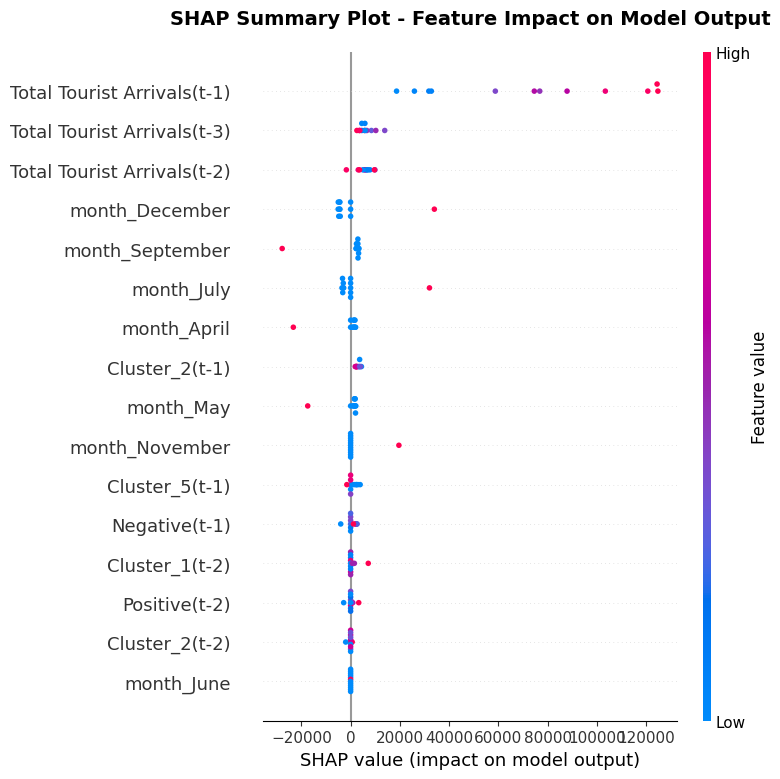

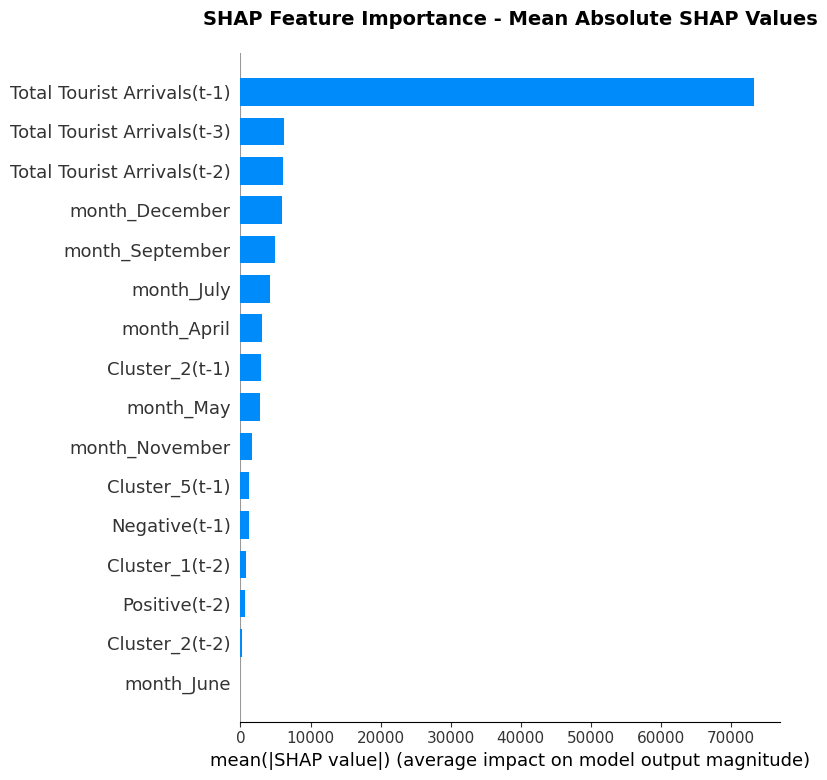


[Step 5] Analyzing individual feature impacts...

FEATURE IMPORTANCE (Top 15)
                    Feature  Mean_Abs_SHAP
Total Tourist Arrivals(t-1)   73360.788525
Total Tourist Arrivals(t-3)    6268.281141
Total Tourist Arrivals(t-2)    6035.752102
             month_December    5905.233007
            month_September    4905.945370
                 month_July    4236.039461
                month_April    3026.992514
             Cluster_2(t-1)    2996.277258
                  month_May    2820.895837
             month_November    1633.003850
             Cluster_5(t-1)    1244.085285
              Negative(t-1)    1201.409370
             Cluster_1(t-2)     775.947858
              Positive(t-2)     615.676858
             Cluster_2(t-2)     219.455162


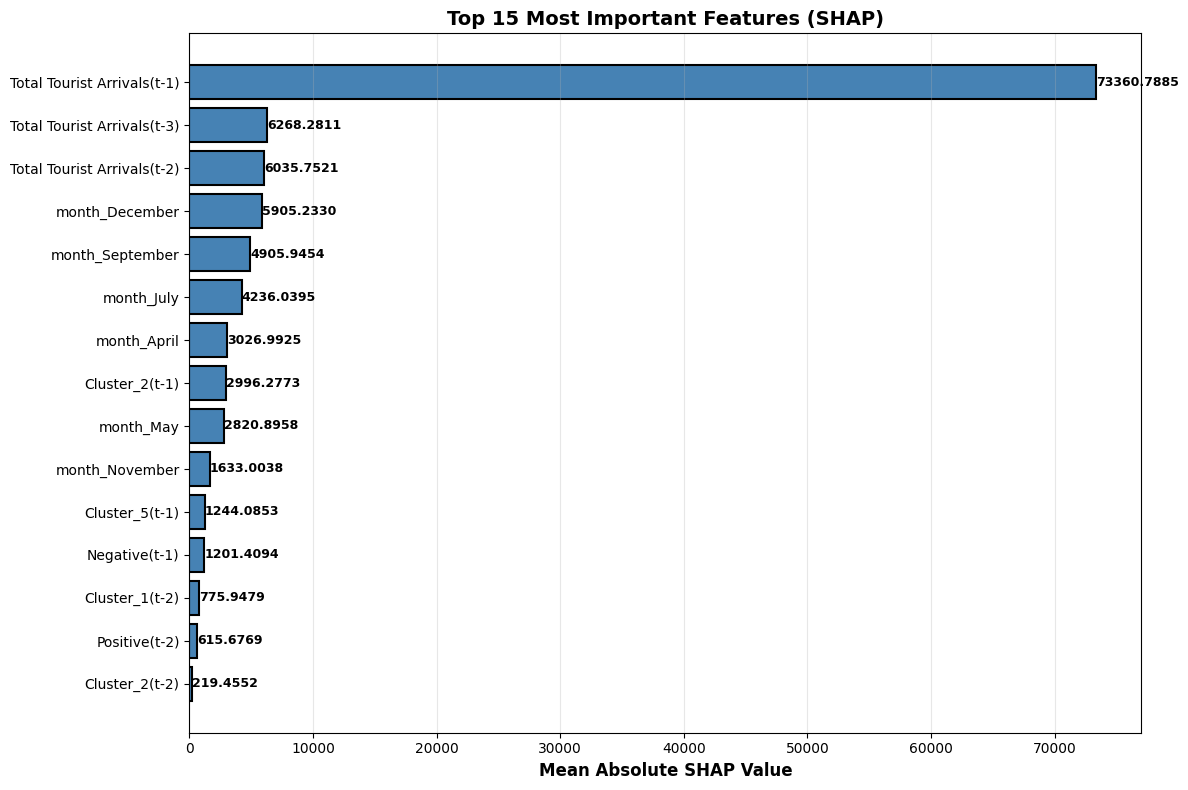


[Step 6] Creating dependence plots for top features...


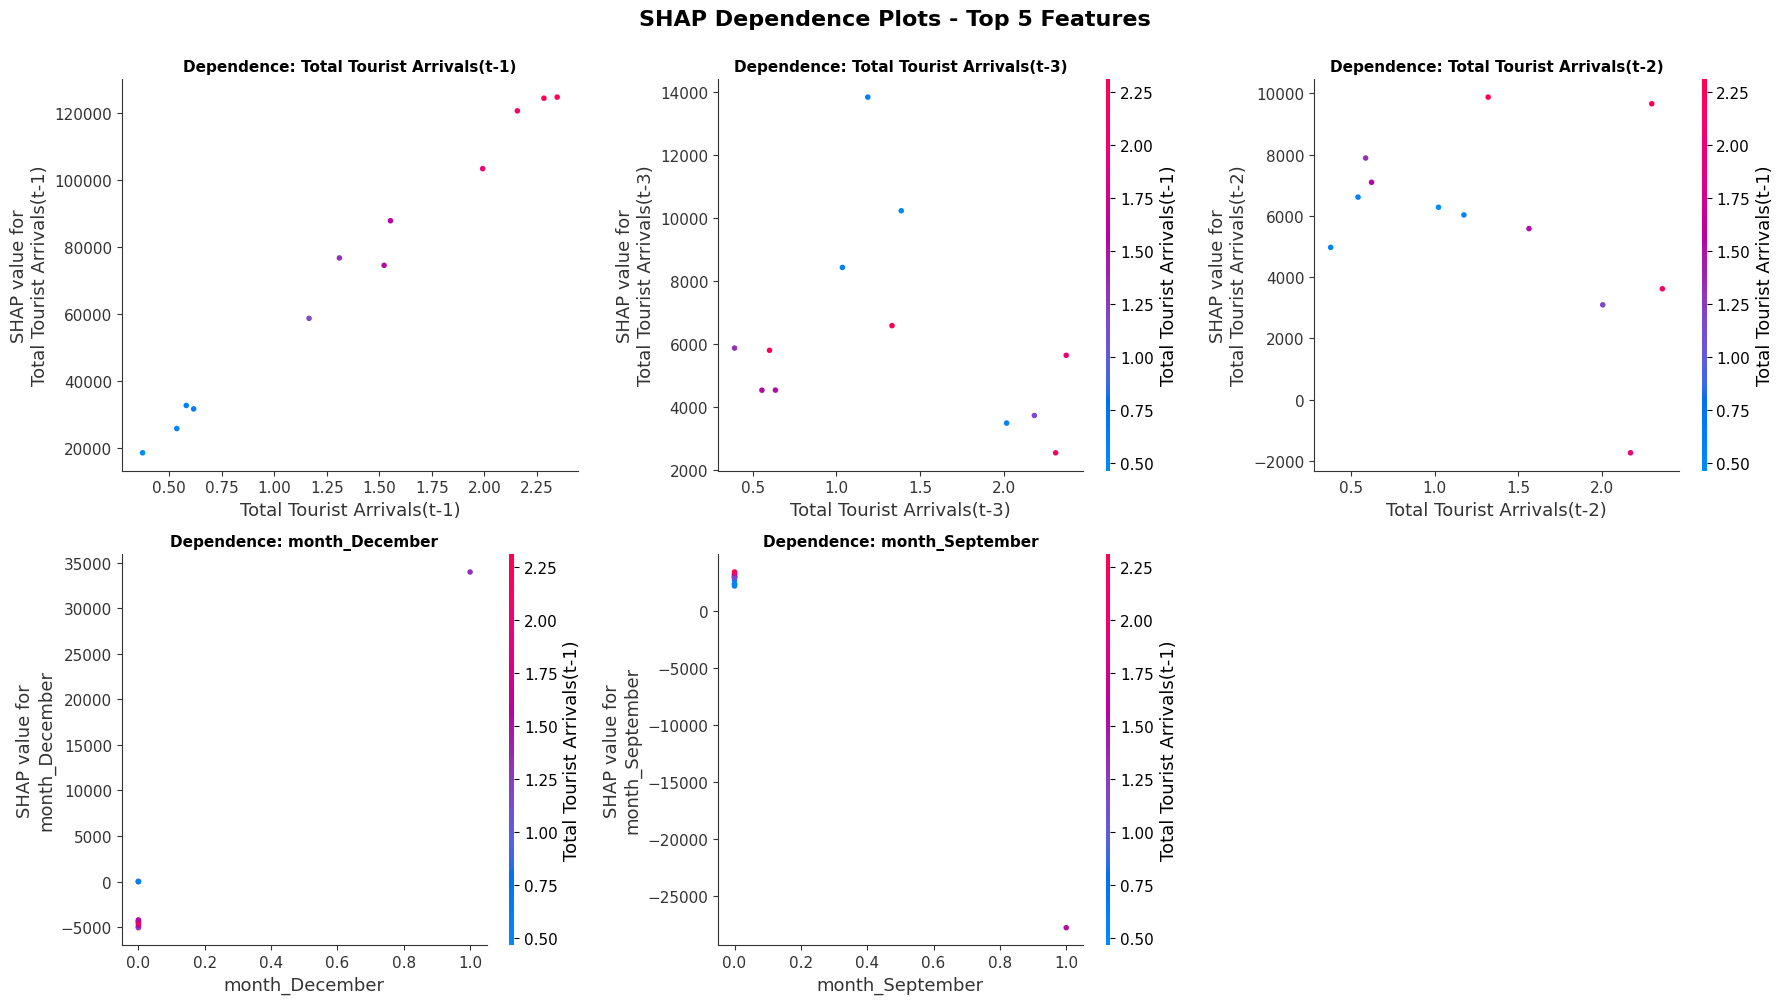


[Step 7] Creating waterfall plots for sample predictions...


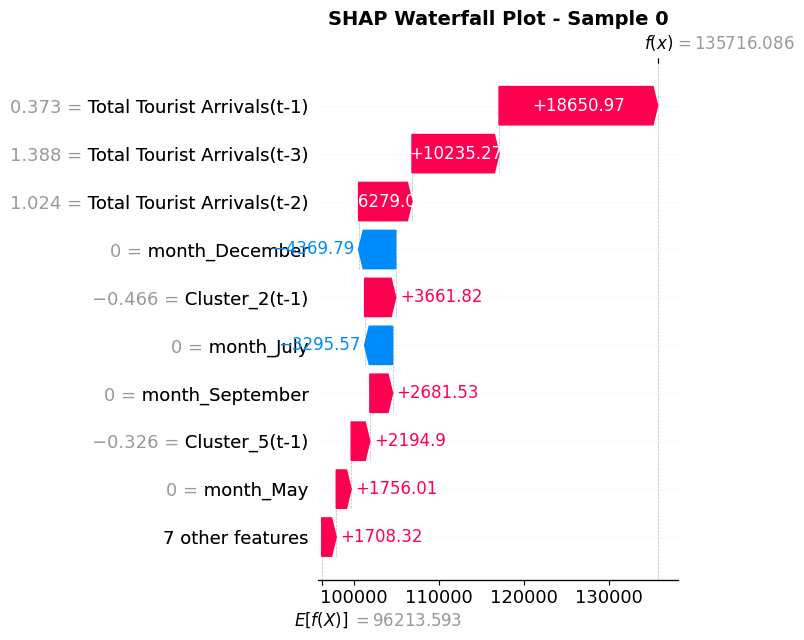

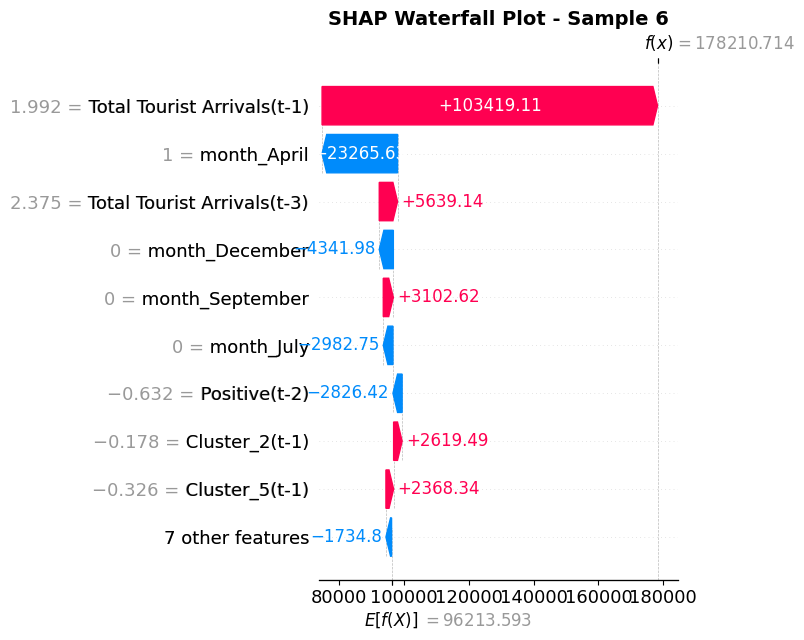

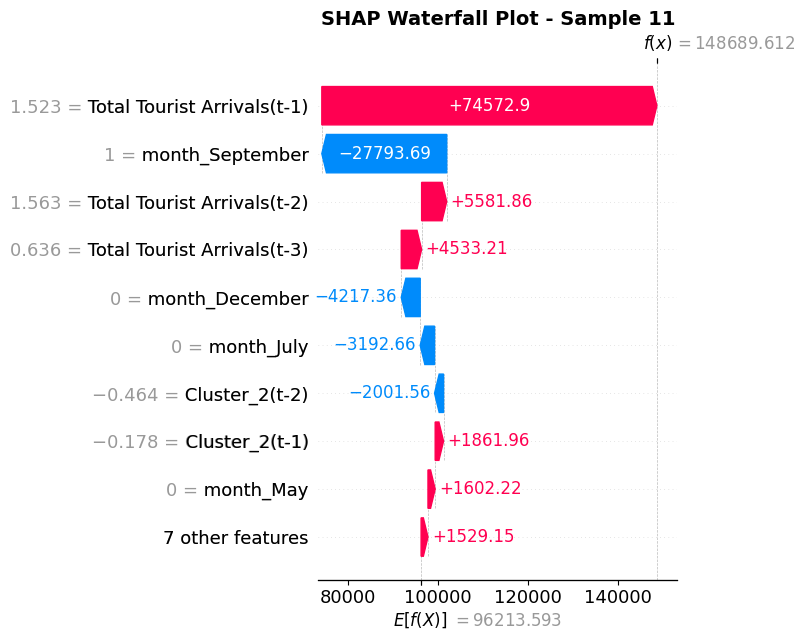


[Step 8] Creating force plots...



Force plot for first test sample:


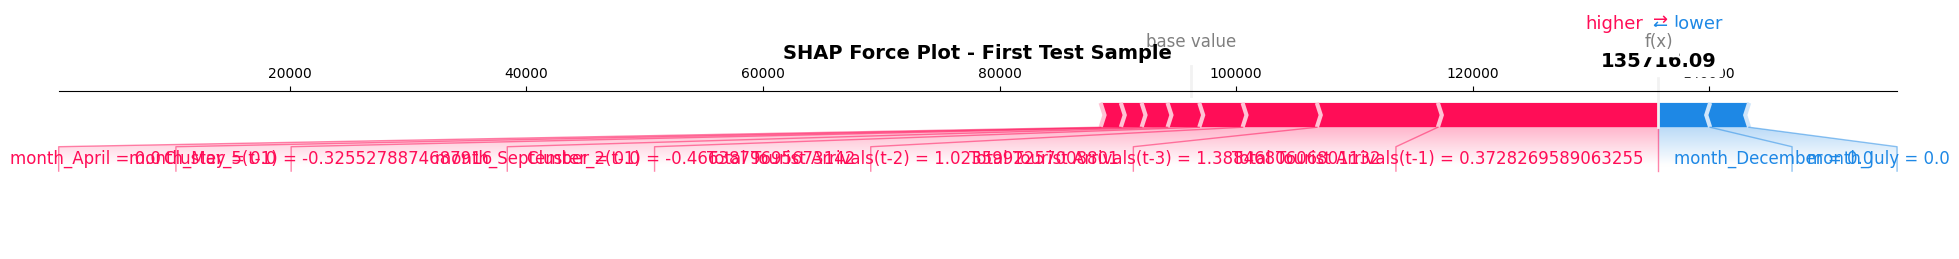


[Step 9] Creating SHAP heatmap...


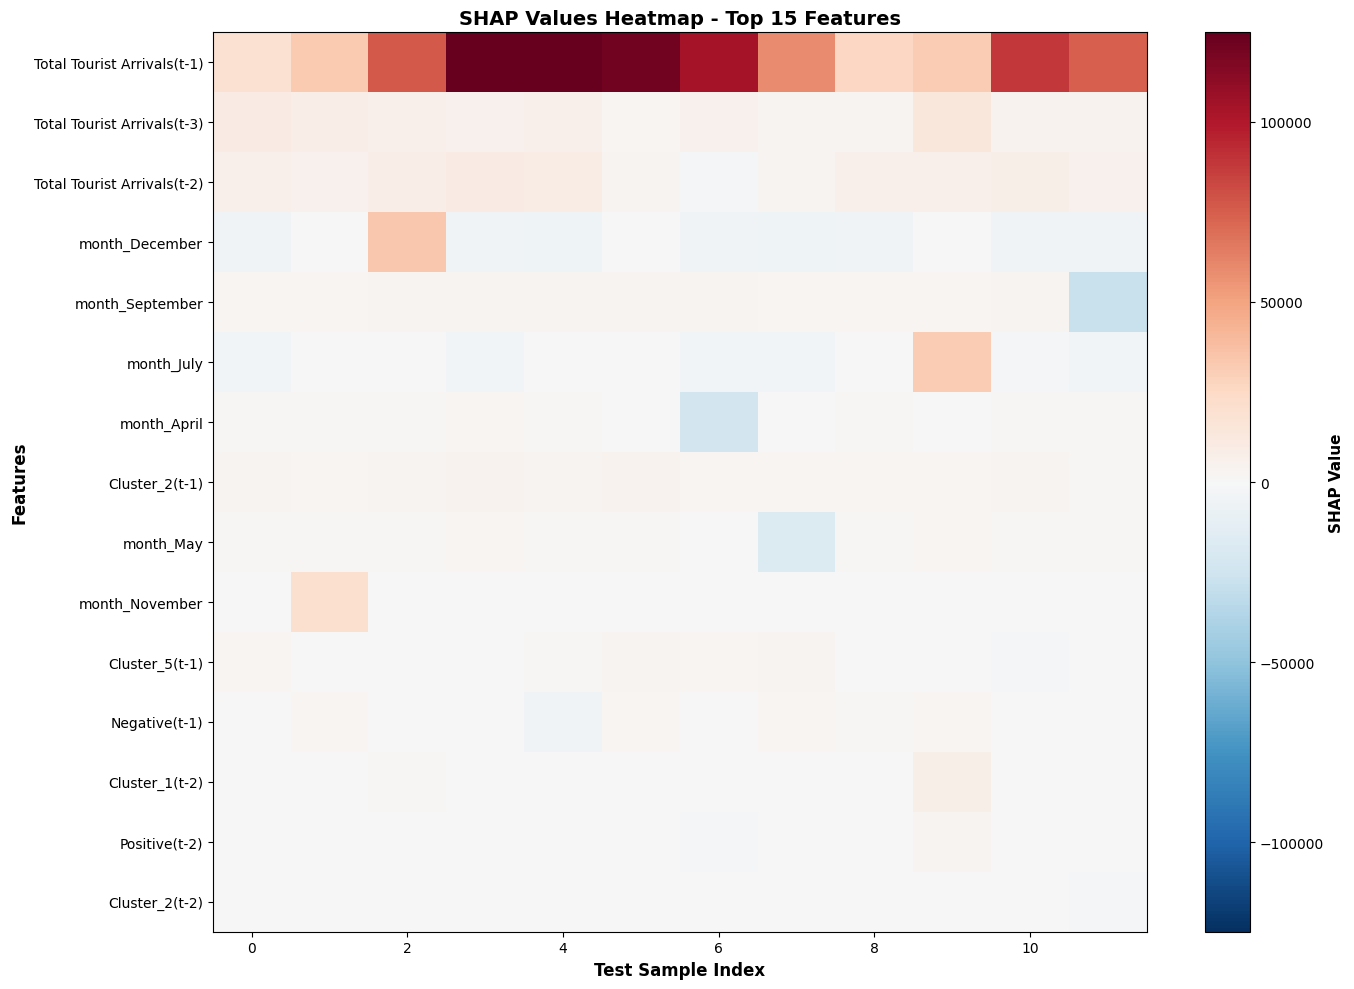


SHAP STATISTICS SUMMARY

Overall SHAP Statistics:
  Mean absolute SHAP value: 7202.861475
  Max SHAP value: 124755.703315
  Min SHAP value: -27793.694876
  Base value (expected): 96213.592633

Feature-wise SHAP Statistics:

Total Tourist Arrivals(t-1):
  Mean SHAP: +73360.788525
  Std SHAP:  38136.598533
  Min SHAP:  +18650.965070
  Max SHAP:  +124755.703315

Total Tourist Arrivals(t-3):
  Mean SHAP: +6268.281141
  Std SHAP:  3066.701988
  Min SHAP:  +2540.447906
  Max SHAP:  +13846.399015

Total Tourist Arrivals(t-2):
  Mean SHAP: +5746.618013
  Std SHAP:  2999.892270
  Min SHAP:  -1734.804535
  Max SHAP:  +9873.668102

month_December:
  Mean SHAP: -239.846845
  Std SHAP:  10509.681508
  Min SHAP:  -5068.002488
  Max SHAP:  +33992.316967

month_September:
  Mean SHAP: +273.662891
  Std SHAP:  8470.217803
  Min SHAP:  -27793.694876
  Max SHAP:  +3407.303580

month_July:
  Mean SHAP: +1099.514957
  Std SHAP:  9441.386545
  Min SHAP:  -3509.709013
  Max SHAP:  +32013.326510

month_April

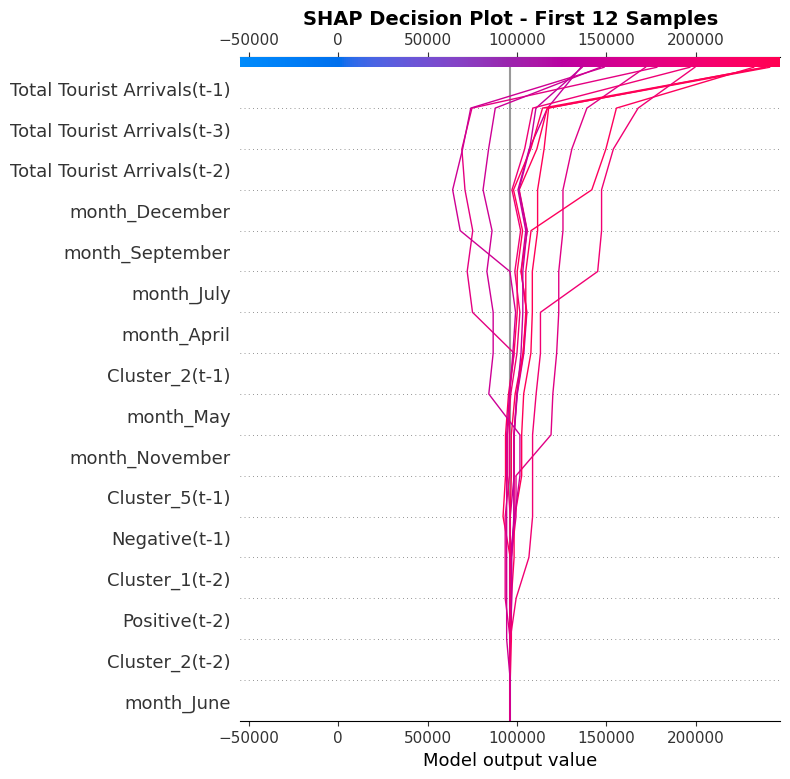


[Step 11] Analyzing positive vs negative impacts...


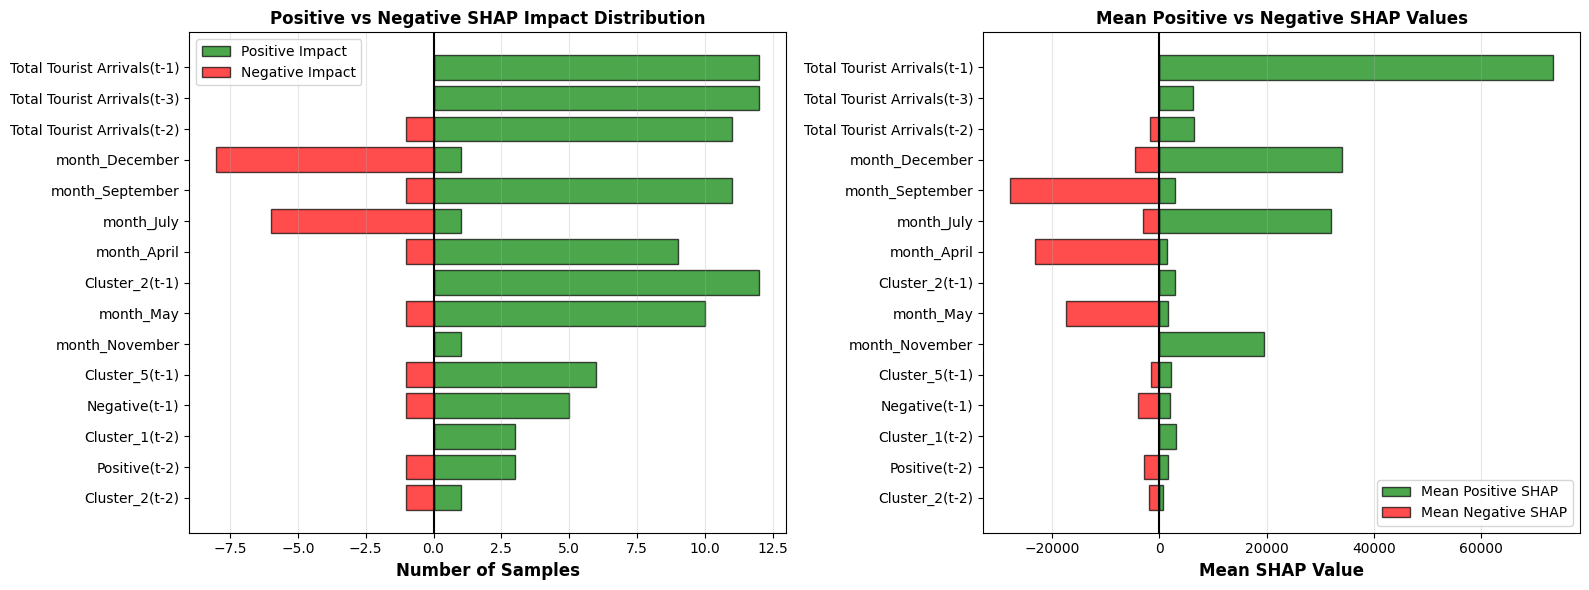


✅ SHAP ANALYSIS COMPLETE!


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 70)
print("SHAP ANALYSIS FOR ANN MODEL")
print("=" * 70)

# =============================================
# STEP 1: Prepare Data for SHAP
# =============================================
print("\n[Step 1] Preparing data for SHAP analysis...")

# Use a sample of the data for faster computation (optional)
# For small datasets, you can use the full dataset
sample_size = min(100, len(X_test_scaled))
X_test_sample = X_test_scaled.iloc[:sample_size]

print(f"Using {sample_size} samples for SHAP analysis")

# =============================================
# STEP 2: Create SHAP Explainer
# =============================================
print("\n[Step 2] Creating SHAP explainer (this may take a few minutes)...")

# For neural networks, we use KernelExplainer or DeepExplainer
# KernelExplainer is model-agnostic and works well for MLPRegressor

# Create a background dataset (use training data summary)
background_size = min(100, len(X_train_scaled))
background = shap.sample(X_train_scaled, background_size)

# Define prediction function
def model_predict(X):
    """Prediction function for SHAP"""
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=X_train_scaled.columns)
    else:
        X_df = X

    predictions_scaled = ann_model.predict(X_df)
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    return predictions

# Create SHAP explainer
explainer = shap.KernelExplainer(model_predict, background)

print("✓ SHAP explainer created successfully!")

# =============================================
# STEP 3: Calculate SHAP Values
# =============================================
print("\n[Step 3] Computing SHAP values...")

shap_values = explainer.shap_values(X_test_sample)

print("✓ SHAP values computed successfully!")
print(f"SHAP values shape: {shap_values.shape}")

# =============================================
# STEP 4: SHAP Summary Plot
# =============================================
print("\n[Step 4] Generating SHAP visualizations...")

# Plot 1: SHAP Summary Plot (Bee Swarm)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output',
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# =============================================
# Plot 2: SHAP Summary Bar Plot (Feature Importance)
# =============================================
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Mean Absolute SHAP Values',
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# =============================================
# STEP 5: Individual Feature Analysis
# =============================================
print("\n[Step 5] Analyzing individual feature impacts...")

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE (Top 15)")
print("=" * 70)
print(feature_importance_df.head(15).to_string(index=False))
print("=" * 70)

# =============================================
# Plot 3: Top Features Bar Chart
# =============================================
fig, ax = plt.subplots(figsize=(12, 8))

top_n = min(15, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['Mean_Abs_SHAP'],
               color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Mean Absolute SHAP Value', fontweight='bold', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features (SHAP)',
            fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['Mean_Abs_SHAP'])):
    ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================
# Plot 4: SHAP Dependence Plots for Top Features
# =============================================
print("\n[Step 6] Creating dependence plots for top features...")

top_5_features = feature_importance_df.head(5)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    if idx < 6:
        shap.dependence_plot(
            feature,
            shap_values,
            X_test_sample,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'Dependence: {feature}', fontweight='bold', fontsize=11)

# Hide unused subplot
if len(top_5_features) < 6:
    axes[5].axis('off')

plt.suptitle('SHAP Dependence Plots - Top 5 Features',
            fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# =============================================
# Plot 5: SHAP Waterfall Plot (Single Prediction)
# =============================================
print("\n[Step 7] Creating waterfall plots for sample predictions...")

# Select a few interesting samples to explain
sample_indices = [0, len(X_test_sample)//2, len(X_test_sample)-1]

for sample_idx in sample_indices:
    fig, ax = plt.subplots(figsize=(10, 8))

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[sample_idx],
            base_values=explainer.expected_value,
            data=X_test_sample.iloc[sample_idx].values,
            feature_names=X_test_sample.columns.tolist()
        ),
        show=False
    )

    plt.title(f'SHAP Waterfall Plot - Sample {sample_idx}',
             fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# =============================================
# Plot 6: SHAP Force Plot
# =============================================
print("\n[Step 8] Creating force plots...")

# Initialize JavaScript for interactive plots (optional)
shap.initjs()

# Force plot for first prediction
print("\nForce plot for first test sample:")
fig = shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test_sample.iloc[0],
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - First Test Sample', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================
# Plot 7: SHAP Heatmap
# =============================================
print("\n[Step 9] Creating SHAP heatmap...")

# Select samples for heatmap (e.g., first 30)
n_samples_heatmap = min(30, len(X_test_sample))

fig, ax = plt.subplots(figsize=(14, 10))

# Sort features by importance for better visualization
feature_order = feature_importance_df['Feature'].tolist()[:15]  # Top 15
feature_indices = [X_test_sample.columns.tolist().index(f) for f in feature_order]

# Create heatmap data
heatmap_data = shap_values[:n_samples_heatmap, feature_indices].T

im = ax.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', vmin=-np.abs(heatmap_data).max(),
               vmax=np.abs(heatmap_data).max())

ax.set_yticks(range(len(feature_order)))
ax.set_yticklabels(feature_order)
ax.set_xlabel('Test Sample Index', fontweight='bold', fontsize=12)
ax.set_ylabel('Features', fontweight='bold', fontsize=12)
ax.set_title('SHAP Values Heatmap - Top 15 Features', fontweight='bold', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('SHAP Value', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# =============================================
# STEP 10: Statistical Summary
# =============================================
print("\n" + "=" * 70)
print("SHAP STATISTICS SUMMARY")
print("=" * 70)

# Overall statistics
print(f"\nOverall SHAP Statistics:")
print(f"  Mean absolute SHAP value: {np.abs(shap_values).mean():.6f}")
print(f"  Max SHAP value: {shap_values.max():.6f}")
print(f"  Min SHAP value: {shap_values.min():.6f}")
print(f"  Base value (expected): {explainer.expected_value:.6f}")

# Feature-wise statistics
print(f"\nFeature-wise SHAP Statistics:")
for i, feature in enumerate(feature_importance_df.head(10)['Feature']):
    feat_idx = X_test_sample.columns.tolist().index(feature)
    feat_shap = shap_values[:, feat_idx]
    print(f"\n{feature}:")
    print(f"  Mean SHAP: {feat_shap.mean():+.6f}")
    print(f"  Std SHAP:  {feat_shap.std():.6f}")
    print(f"  Min SHAP:  {feat_shap.min():+.6f}")
    print(f"  Max SHAP:  {feat_shap.max():+.6f}")

print("\n" + "=" * 70)

# =============================================
# Plot 8: SHAP Decision Plot
# =============================================
print("\n[Step 10] Creating decision plot...")

fig, ax = plt.subplots(figsize=(12, 10))

# Select a subset of samples for clarity
n_decision_samples = min(20, len(X_test_sample))

shap.decision_plot(
    explainer.expected_value,
    shap_values[:n_decision_samples],
    X_test_sample.iloc[:n_decision_samples],
    feature_names=X_test_sample.columns.tolist(),
    show=False
)

plt.title(f'SHAP Decision Plot - First {n_decision_samples} Samples',
         fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================
# Plot 9: Positive vs Negative Impact
# =============================================
print("\n[Step 11] Analyzing positive vs negative impacts...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate positive and negative impacts
positive_impact = (shap_values > 0).sum(axis=0)
negative_impact = (shap_values < 0).sum(axis=0)

top_features_idx = feature_importance_df.head(15).index

ax1 = axes[0]
features_subset = feature_importance_df.head(15)['Feature']
pos_counts = [positive_impact[X_test_sample.columns.tolist().index(f)] for f in features_subset]
neg_counts = [negative_impact[X_test_sample.columns.tolist().index(f)] for f in features_subset]

y_pos = np.arange(len(features_subset))
ax1.barh(y_pos, pos_counts, color='green', alpha=0.7, label='Positive Impact', edgecolor='black')
ax1.barh(y_pos, [-x for x in neg_counts], color='red', alpha=0.7, label='Negative Impact', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(features_subset)
ax1.set_xlabel('Number of Samples', fontweight='bold', fontsize=12)
ax1.set_title('Positive vs Negative SHAP Impact Distribution', fontweight='bold', fontsize=12)
ax1.legend()
ax1.axvline(x=0, color='black', linewidth=1.5)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Mean positive and negative SHAP values
ax2 = axes[1]
mean_pos_shap = [shap_values[:, X_test_sample.columns.tolist().index(f)][shap_values[:, X_test_sample.columns.tolist().index(f)] > 0].mean()
                 if (shap_values[:, X_test_sample.columns.tolist().index(f)] > 0).any() else 0
                 for f in features_subset]
mean_neg_shap = [shap_values[:, X_test_sample.columns.tolist().index(f)][shap_values[:, X_test_sample.columns.tolist().index(f)] < 0].mean()
                 if (shap_values[:, X_test_sample.columns.tolist().index(f)] < 0).any() else 0
                 for f in features_subset]

ax2.barh(y_pos, mean_pos_shap, color='green', alpha=0.7, label='Mean Positive SHAP', edgecolor='black')
ax2.barh(y_pos, mean_neg_shap, color='red', alpha=0.7, label='Mean Negative SHAP', edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(features_subset)
ax2.set_xlabel('Mean SHAP Value', fontweight='bold', fontsize=12)
ax2.set_title('Mean Positive vs Negative SHAP Values', fontweight='bold', fontsize=12)
ax2.legend()
ax2.axvline(x=0, color='black', linewidth=1.5)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ SHAP ANALYSIS COMPLETE!")
print("=" * 70)

# LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import optuna

# -----------------------------
# RESHAPE FOR LSTM
# (timesteps = 1, features = n_features)
# -----------------------------
X_train_lstm = X_train_scaled.values.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_lstm = X_test_scaled.values.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# -----------------------------
# OPTUNA OBJECTIVE FUNCTION
# -----------------------------
def objective_lstm(trial):

    tf.keras.backend.clear_session()

    n_units = trial.suggest_int("n_units", 1, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13])
    epochs = 60

    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_lstm):

        X_t, X_v = X_train_lstm[train_idx], X_train_lstm[val_idx]
        y_t, y_v = y_train_scaled.iloc[train_idx], y_train_scaled.iloc[val_idx]

        model = Sequential([
            Input(shape=(X_t.shape[1], X_t.shape[2])),
            LSTM(n_units),
            Dropout(dropout),
            Dense(1)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="mse"
        )

        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ]

        model.fit(
            X_t, y_t,
            validation_data=(X_v, y_v),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        preds = model.predict(X_v, verbose=0)
        fold_losses.append(mean_squared_error(y_v, preds))

    return np.mean(fold_losses)

# -----------------------------
# RUN OPTUNA
# -----------------------------
study_lstm = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_lstm.optimize(objective_lstm, n_trials=20)

best_params_lstm = study_lstm.best_params
print("Best LSTM Params:", best_params_lstm)

# -----------------------------
# FINAL LSTM MODEL
# -----------------------------
tf.keras.backend.clear_session()

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(best_params_lstm["n_units"]),
    Dropout(best_params_lstm["dropout"]),
    Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params_lstm["lr"]
    ),
    loss="mse"
)

final_callbacks = [
    EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True
    )
]

lstm_model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=80,
    batch_size=best_params_lstm["batch_size"],
    callbacks=final_callbacks,
    verbose=1
)

# -----------------------------
# PREDICTIONS & INVERSE SCALE
# -----------------------------
train_pred_scaled = lstm_model.predict(X_train_lstm)
test_pred_scaled = lstm_model.predict(X_test_lstm)

train_pred = scaler_y.inverse_transform(train_pred_scaled).ravel()
test_pred = scaler_y.inverse_transform(test_pred_scaled).ravel()

# -----------------------------
# TRAIN METRICS
# -----------------------------
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("\n==== LSTM TRAIN METRICS ====")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"MAPE : {train_mape:.4f}")
print(f"R²   : {train_r2:.4f}")

# -----------------------------
# TEST METRICS
# -----------------------------
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== LSTM TEST METRICS ====")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"MAE  : {test_mae:.4f}")
print(f"MAPE : {test_mape:.4f}")
print(f"R²   : {test_r2:.4f}")


[I 2026-02-04 06:21:54,775] A new study created in memory with name: no-name-75ba6c73-9a2c-4ee9-bd1e-61fd555c54ae
[I 2026-02-04 06:22:43,282] Trial 0 finished with value: 0.1915863316515092 and parameters: {'n_units': 24, 'dropout': 0.3802857225639665, 'lr': 0.0029106359131330704, 'batch_size': 10}. Best is trial 0 with value: 0.1915863316515092.
[I 2026-02-04 06:23:31,680] Trial 1 finished with value: 0.2876782093768401 and parameters: {'n_units': 12, 'dropout': 0.1216968971838151, 'lr': 0.0011207606211860567, 'batch_size': 9}. Best is trial 0 with value: 0.1915863316515092.
[I 2026-02-04 06:24:41,468] Trial 2 finished with value: 0.3215565786873217 and parameters: {'n_units': 39, 'dropout': 0.06820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 3}. Best is trial 0 with value: 0.1915863316515092.
[I 2026-02-04 06:25:48,480] Trial 3 finished with value: 0.1765851254109293 and parameters: {'n_units': 43, 'dropout': 0.12468443043576438, 'lr': 0.001096821720752952, 'batch_size':

Best LSTM Params: {'n_units': 21, 'dropout': 0.20751624869734644, 'lr': 0.0025470526233391183, 'batch_size': 3}
Epoch 1/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9981
Epoch 2/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2950
Epoch 3/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1483
Epoch 4/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1197
Epoch 5/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1047
Epoch 6/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1160
Epoch 7/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936
Epoch 8/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0764
Epoch 9/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0823
Epoch 10/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786
Epoch 11/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0874
Epoch 12/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843
Epoch 13/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0741
Epoch 14/80
74/74 ━━━━━━━━━━━━━━━━━━━━ 